# 1 Installation

In [1]:
import os
import sys
print(f"Python executable: {sys.executable}")

Python executable: /Users/martincastro/Downloads/img/venv/bin/python


In [2]:
import pandas as pd
print("Pandas version:", pd.__version__)

Pandas version: 2.0.3


In [3]:
import numpy as np

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, Subset

In [5]:
import torchvision.transforms as transforms

/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
from transformers import ViTForImageClassification

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

In [8]:
from PIL import Image

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
import random
from datetime import datetime, timedelta
import time

In [11]:
from typing import List, Tuple

In [12]:
from apparel import ApparelDataset, ApparelStackedDataset, ApparelProfiler

# 2 Settings

In [13]:
LABELS = {
    0: 'T-Shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot'
}

In [14]:
def get_label_by_value(value):
    for key, val in LABELS.items():
        if val == value:
            return key
    return None

In [15]:
WEIGHTS = {
    0: 2,
    1: 1,
    2: 2,
    3: 2,
    4: 3,  # Coas are also hard to classify.
    5: 1,
    6: 3,  # The largest amount of errors in the confusion matrix lie here.
    7: 1,
    8: 1,
    9: 1
}

In [16]:
MODEL_PATH = "models/v5.h5"

In [17]:
PREDICTIONS_PATH = "predictions/v5.csv"

In [18]:
BATCH_SIZE = 64  # Samples per batch to load during training.

In [19]:
IMAGE_SIZE = 224  # Balance between image detail and computational cost.

In [20]:
SAMPLE_COLUMNS = 5
SAMPLE_ROWS = 4

In [21]:
RANDOM_STATE = 53  # Seed for randomized functions.

np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
# tf.random.set_seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [22]:
VALIDATION_SPLIT_RATIO = 0.2  # Ratio of validation datapoints.
TEST_SPLIT_RATIO = 0.5  # Ratio of test datapoints.

In [23]:
EPOCHS = 10  # Iterations during the training process.

In [24]:
PROCESSOR = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Processor:', PROCESSOR)

Processor: cpu


In [25]:
EARLY_STOPPING_PATIENCE = 3  # Number of epochs to wait for improvement before stopping

In [26]:
DROPOUT_RATE = 0.1  # Probability of dropping a weight during the training process.

In [27]:
LOADER_WORKERS = 4  # Amount of workers to use to load images.

In [28]:
AUGMENTED_RECORDS = 0.3  # Amount of records to include in data augmentation.

In [29]:
PRETRAINED_TRANSFORMER_NAME = 'google/vit-base-patch16-224'  # Too heavy but more powerful.
PRETRAINED_TRANSFORMER_NAME = 'facebook/deit-tiny-patch16-224'

In [30]:
STOP_AT_BATCH = None  # This is for debugging purposes. Should be set to None.

# 3 Data Loading

In this section, we define a custom dataset class `ApparelDataset` that extends the `Dataset` class from PyTorch. This custom dataset is designed to load images and their corresponding labels from a CSV file and a specified directory.

In [31]:
preprocessing = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
])

train_dataset = ApparelDataset.load(csv_path='data/train.csv', images_path='data/train', preprocessing=preprocessing)
print("Training dataset:", train_dataset, len(train_dataset), "records.")

Training dataset: <apparel.ApparelDataset object at 0x15deecaf0> 60000 records.


# 4 Initial Exploratory Analysis

Performing an initial exploratory analysis of our dataset to understand its content. Additionally, plotting the distribution of labels to ensure the dataset is balanced.

In [32]:
print(train_dataset.df.dtypes)

id       int64
label    int64
dtype: object


In [33]:
def sample_dataset(dataset: Dataset) -> None:
    random_indices = random.sample(range(len(dataset)), SAMPLE_ROWS * SAMPLE_COLUMNS)
    random_images = [dataset[i][0] for i in random_indices]
    random_labels = [dataset[i][1] for i in random_indices]
    sample_images(random_images, random_labels)

In [34]:
def sample_images(images: List[np.array], labels: List[int]) -> None:
    plt.figure(figsize=(20, 10))
    for i in range(len(images)):
        ax = plt.subplot(SAMPLE_ROWS, SAMPLE_COLUMNS, i + 1)  # Show 2 rows of 5 images.
        img = images[i].permute(1, 2, 0)  # Convert from CxHxW to HxWxC
        plt.imshow(img)
        plt.title(LABELS[labels[i].item()])  # The title of each image is the label.
        plt.axis("off")  # Hide the X and Y grid.
    plt.show()

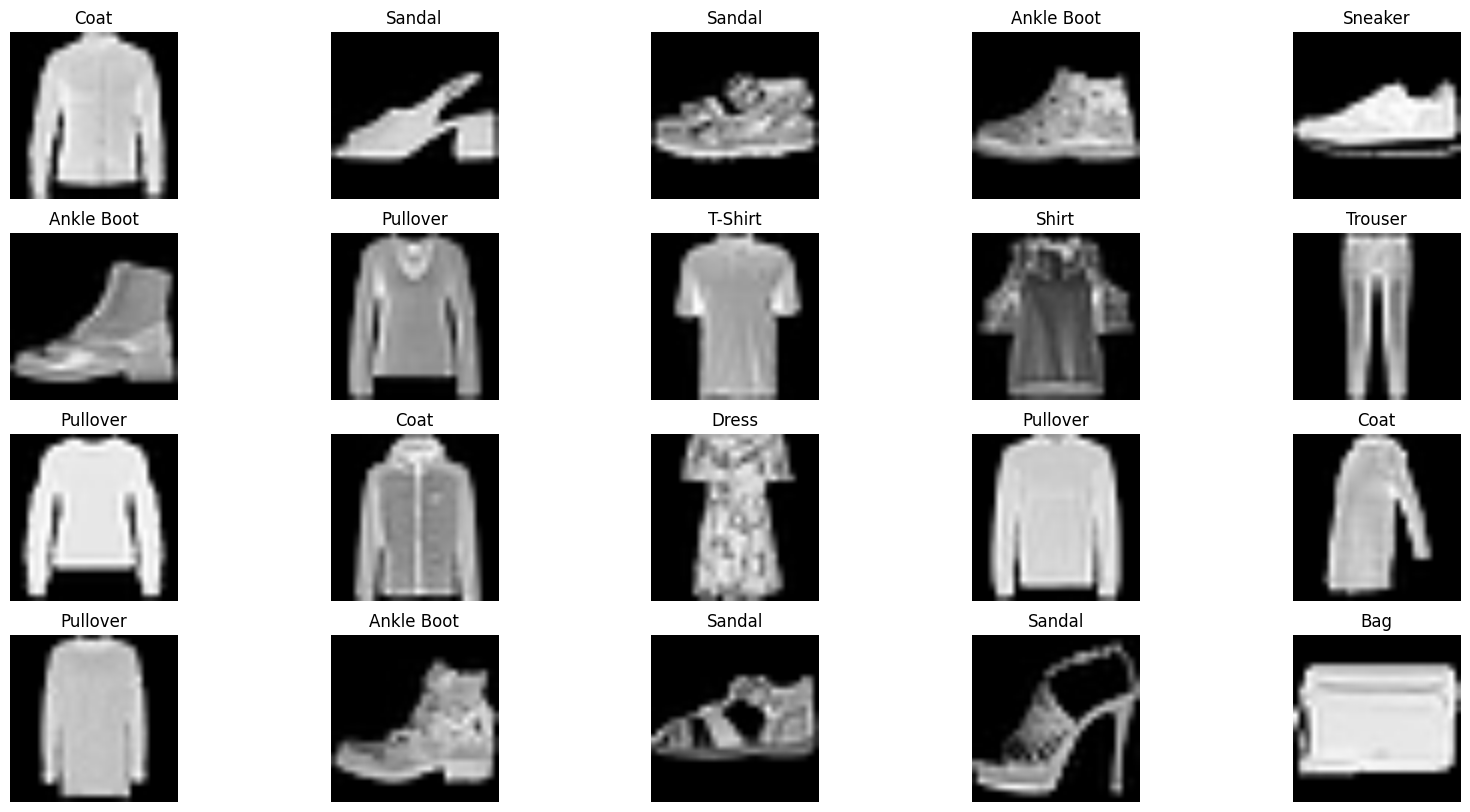

In [35]:
sample_dataset(train_dataset)

In [36]:
def plot_labels(dataset: Dataset) -> None:
    df = dataset.df
    df['label_names'] = df['label'].map(LABELS)
    plt.figure(figsize=(10, 6))
    sns.histplot(df['label_names'], bins=len(df['label'].unique()), kde=False)
    plt.xlabel('Label')
    plt.ylabel('Frequency')
    plt.show()

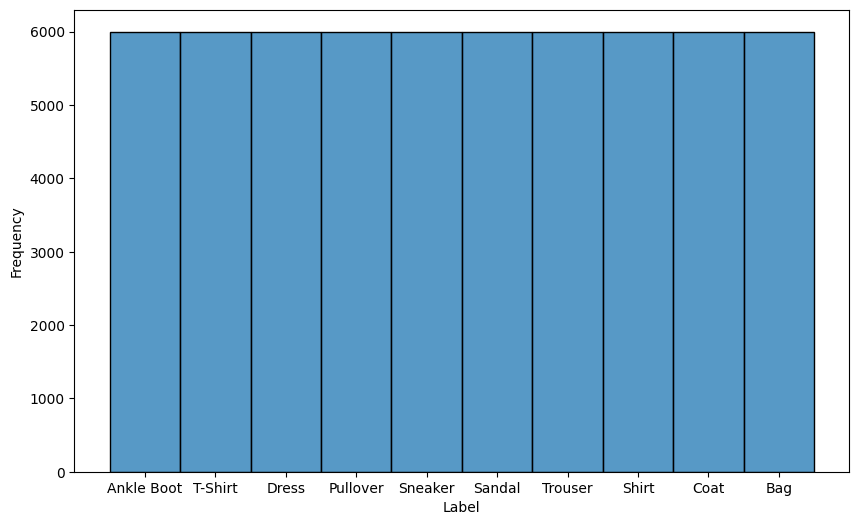

In [37]:
plot_labels(train_dataset)

# 5 Data Cleaning

Checking for null and duplicated values in the dataset. Fortunately, this dataset is already clean and balanced.

In [38]:
print("Null ids:", train_dataset.df.id.isnull().sum())

Null ids: 0


In [39]:
print("Null labels:", train_dataset.df.label.isnull().sum())

Null labels: 0


In [40]:
print("Duplicated rows:", train_dataset.df.duplicated().sum())

Duplicated rows: 0


# 6 Data Augmentation

Increasing the diversity of the training dataset to improve the robustness of our machine learning model. The augmented images are then combined with the original training dataset. This combined dataset is used to train the model.

In [41]:
augmentation = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(p=0.1),  # Horizontally flip the input with a given probability.
    transforms.RandomRotation(degrees=90),  # Rotate the input by angle.
    transforms.RandomPerspective(p=0.1),  # Perform a random perspective transformation of the input with a given probability.
    # transforms.RandomResizedCrop(size=(IMAGE_SIZE, IMAGE_SIZE), antialias=True),  # Crop a random portion of the input and resize it to a given size.
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

augmented_dataset = ApparelDataset.load(csv_path='data/train.csv', images_path='data/train', preprocessing=augmentation, sample=AUGMENTED_RECORDS)
print("Augmentation dataset:", augmented_dataset, len(augmented_dataset), "records")

Augmentation dataset: <apparel.ApparelDataset object at 0x15e766f70> 18000 records


In [42]:
tshirt_augmentation = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(p=0.1),  # Horizontally flip the input with a given probability.
    transforms.RandomRotation(degrees=90),  # Rotate the input by angle.
    transforms.RandomPerspective(p=0.1),  # Perform a random perspective transformation of the input with a given probability.
    transforms.ToTensor(),
])

tshirt = get_label_by_value('T-Shirt')
tshirt_dataset = ApparelDataset.load(
    csv_path='data/train.csv',
    images_path='data/train',
    preprocessing=tshirt_augmentation,
    sample=AUGMENTED_RECORDS,
    labels=[tshirt]
)
print("T-Shirt dataset:", tshirt_dataset, len(tshirt_dataset), "records")

T-Shirt dataset: <apparel.ApparelDataset object at 0x15e686910> 1808 records


In [43]:
augmented_train_dataset = ApparelStackedDataset(train_dataset, augmented_dataset, tshirt_dataset)
print("Augmented training dataset dataset:", augmented_train_dataset, len(augmented_train_dataset), "records")

assert len(augmented_train_dataset) == len(train_dataset) + len(augmented_dataset) + len(tshirt_dataset)
assert augmented_train_dataset[0][0].equal(train_dataset[0][0])
assert augmented_train_dataset[0][1] == train_dataset[0][1]
# assert augmented_train_dataset[len(train_dataset)][0].equal(augmented_dataset[0][0])  # Reading the image generates a random variant.
assert augmented_train_dataset[len(train_dataset)][1] == augmented_dataset[0][1]
assert augmented_train_dataset[len(train_dataset) + len(augmented_dataset)][1] == tshirt_dataset[0][1]

Augmented training dataset dataset: <apparel.ApparelStackedDataset object at 0x15e7b9fd0> 79808 records


# 7 Post-Cleaning Exploratory Analysis

Repeating the exploratory analysis to verify the effectiveness of the data cleaning and augmentation steps. This ensures the data augmentation step has not created weird things.

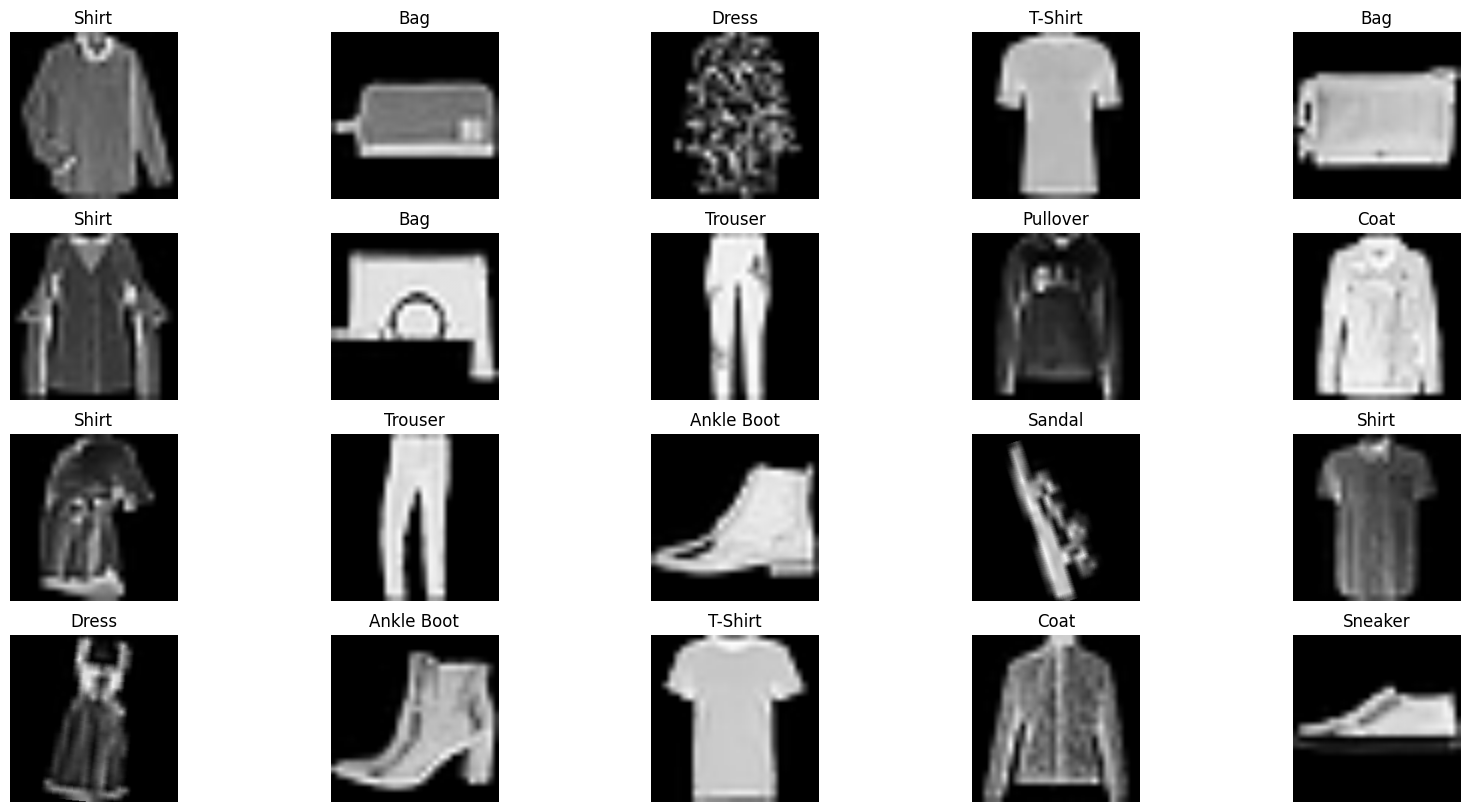

In [44]:
sample_dataset(augmented_train_dataset)

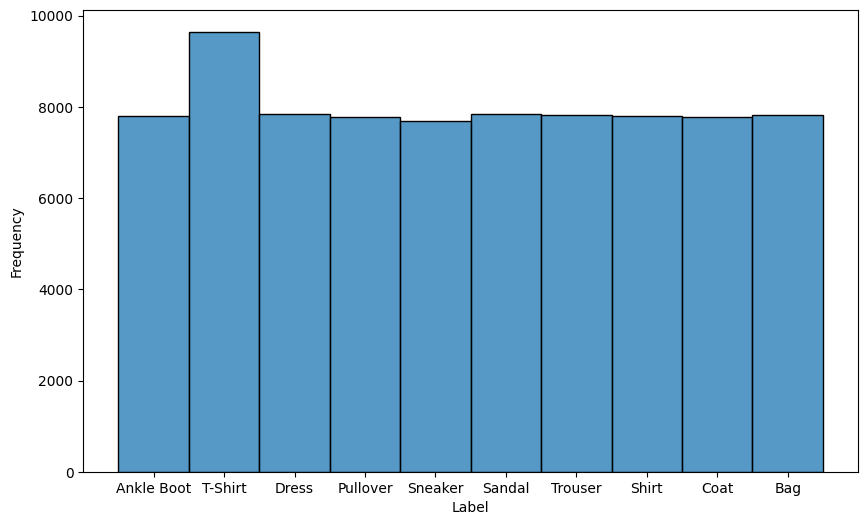

In [45]:
plot_labels(augmented_train_dataset)

# 8 Training and Validation Splitting

Splitting the augmented training dataset into training and validation sets using stratified sampling to maintain the same class distribution across both sets.

In [46]:
df = augmented_train_dataset.df
train_indices, val_test_indices = train_test_split(
    list(range(len(augmented_train_dataset))), 
    test_size=VALIDATION_SPLIT_RATIO, 
    stratify=df.label, 
    random_state=RANDOM_STATE
)
val_indices, test_indices = train_test_split(
    val_test_indices, 
    test_size=TEST_SPLIT_RATIO, 
    stratify=[df.label[i] for i in val_test_indices], 
    random_state=RANDOM_STATE
)
assert len(augmented_train_dataset) == len(train_indices) + len(test_indices) + len(val_indices)


print("Training indices:", train_indices[:10], "...")
print("Test indices:", test_indices[:10], "...")
print("Validation indices:", val_indices[:10], "...")

Training indices: [37558, 35258, 68615, 62659, 27753, 25911, 75569, 50599, 28888, 12927] ...
Test indices: [30878, 66682, 65308, 66786, 7366, 50985, 61133, 37865, 73970, 43775] ...
Validation indices: [22732, 46894, 64558, 74973, 73201, 24439, 69198, 28603, 69192, 76335] ...


In [47]:
train_subset = Subset(augmented_train_dataset, train_indices)
test_subset = Subset(augmented_train_dataset, test_indices)
val_subset = Subset(augmented_train_dataset, val_indices)
assert len(train_subset) + len(test_subset) + len(val_subset) == len(augmented_train_dataset)
print("Training dataset:", train_subset, len(train_subset), "records")
print("Test dataset:", test_subset, len(test_subset), "records")
print("Validation dataset:", val_subset, len(val_subset), "records")

Training dataset: <torch.utils.data.dataset.Subset object at 0x15ee7b7c0> 63846 records
Test dataset: <torch.utils.data.dataset.Subset object at 0x15ee7bbb0> 7981 records
Validation dataset: <torch.utils.data.dataset.Subset object at 0x15ee7b850> 7981 records


In [48]:
train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=LOADER_WORKERS, pin_memory=False)
test_loader = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=LOADER_WORKERS, pin_memory=False)
val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=LOADER_WORKERS, pin_memory=False)

# 8 Model Preparation

Loading a pre-trained Vision Transformer model specifically designed for image classification with 10 labels using `ViTForImageClassification` from the Hugging Face, which is configured for a GPU (if available). Additionally, an Adam optimizer is set up with a learning rate of `1e-4` to adjust the model's parameters during training, and a cross-entropy loss function is defined to measure the performance of the model by comparing its predictions against the true labels.

In [49]:
class ApparelsModel(nn.Module):
    def __init__(self, base_model, num_labels):
        super(ApparelsModel, self).__init__()

        self.base_model = base_model

        # Freeze the base model
        for param in self.base_model.parameters():
            param.requires_grad = False

        LAYER_1 = 8192
        LAYER_2 = 2048
        LAYER_3 = 512
        
        self.new_layers = nn.Sequential(
            nn.Linear(base_model.config.hidden_size, LAYER_1),
            nn.BatchNorm1d(LAYER_1),  # Adding Batch Normalization
            nn.ReLU(),
            nn.Dropout(DROPOUT_RATE),  # Adding dropout to reduce overfitting.

            nn.Linear(LAYER_1, LAYER_2),
            nn.BatchNorm1d(LAYER_2),  # Adding Batch Normalization
            nn.ReLU(),
            nn.Dropout(DROPOUT_RATE),  # Adding dropout to reduce overfitting.

            nn.Linear(LAYER_2, LAYER_3),
            nn.BatchNorm1d(LAYER_3),  # Adding Batch Normalization
            nn.ReLU(),
            nn.Dropout(DROPOUT_RATE),  # Adding dropout to reduce overfitting.
            nn.Linear(LAYER_3, num_labels)
        )
        
    def forward(self, x):
        x = self.base_model.vit(x)  # Pass through the base ViT model
        x = x.last_hidden_state[:, 0]  # Get the output of the [CLS] token
        x = self.new_layers(x)  # Pass through the new layers
        return x

    def forward(self, x):
        # profiler = ApparelProfiler("Forward")
        # profiler.measure("BaseModel")
        x = self.base_model.vit(x)
        # profiler.measure("NewLayers")
        x = x.last_hidden_state[:, 0]
        x = self.new_layers(x)
        # profiler.stop()
        return x

In [50]:
base_model = ViTForImageClassification.from_pretrained(
    PRETRAINED_TRANSFORMER_NAME,
    ignore_mismatched_sizes=True,
    num_labels=len(LABELS)
)

model = ApparelsModel(base_model, num_labels=len(LABELS))
model = model.to(PROCESSOR)
print("Model:", model)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/deit-tiny-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 192]) in the checkpoint and torch.Size([10, 192]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: ApparelsModel(
  (base_model): ViTForImageClassification(
    (vit): ViTModel(
      (embeddings): ViTEmbeddings(
        (patch_embeddings): ViTPatchEmbeddings(
          (projection): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): ViTEncoder(
        (layer): ModuleList(
          (0-11): 12 x ViTLayer(
            (attention): ViTSdpaAttention(
              (attention): ViTSdpaSelfAttention(
                (query): Linear(in_features=192, out_features=192, bias=True)
                (key): Linear(in_features=192, out_features=192, bias=True)
                (value): Linear(in_features=192, out_features=192, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
              (output): ViTSelfOutput(
                (dense): Linear(in_features=192, out_features=192, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
        

In [51]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
class_weights = torch.tensor([
    WEIGHTS.get(i, 1)
    for i in range(len(LABELS))
], dtype=torch.float).to(PROCESSOR)
loss_function = torch.nn.CrossEntropyLoss(weight=class_weights)
print("Optimizer:", optimizer)
print("Loss function:", loss_function)

Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)
Loss function: CrossEntropyLoss()


# 10 Model Training

Training the model, including forward and backward passes, validation, and early stopping.

In [52]:
def get_eta(start_time: float, current_batch: int, total_batches: int) -> datetime:
    elapsed_time = time.time() - start_time
    average_time_per_batch = elapsed_time / max(1, current_batch)
    pending_batches = total_batches - current_batch
    return datetime.now() + timedelta(seconds=average_time_per_batch * pending_batches)

In [53]:
def train_epoch(model: ApparelsModel) -> ApparelsModel:
    model.train()
    start_time = time.time()
    for batch_number, batch in enumerate(train_loader):
        print(datetime.now(), "Train - Batch:", batch_number, "of", len(train_loader), "ETA:", get_eta(start_time, batch_number, len(train_loader)))
        inputs, labels = batch[0].to(PROCESSOR), batch[1].to(PROCESSOR)
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if batch_number == STOP_AT_BATCH: break
    return model

In [54]:
def evaluate_model(model: ApparelsModel, loader: DataLoader) -> Tuple[float, float, np.array]:
    loss = 0
    y_hat = []
    y_true = []
    model.eval() # Sets the model in evaluation model, which disables Dropout.
    start_time = time.time()
    with torch.no_grad():
        for batch_number, batch in enumerate(loader):
            print(datetime.now(), "Val - Batch:", batch_number, "of", len(loader), "ETA:", get_eta(start_time, batch_number, len(loader)))
            inputs, labels = batch[0].to(PROCESSOR), batch[1].to(PROCESSOR)
            outputs = model(inputs)
            batch_loss = loss_function(outputs, labels)
            loss += batch_loss.item()
            predictions = torch.argmax(outputs, dim=1)
            y_hat.extend(predictions.cpu().numpy())
            y_true.extend(labels.cpu().numpy())
            if batch_number == STOP_AT_BATCH: break
    loss /= len(loader)
    accuracy = accuracy_score(y_true, y_hat)
    conf_matrix = confusion_matrix(y_true, y_hat)
    return loss, accuracy, conf_matrix

In [55]:
def train(model: ApparelsModel, epochs: int, best_loss: float = float('inf')) -> Tuple[ApparelsModel, List[float]]:
    early_stop_counter = 0
    accuracies: List[float] = []
    for epoch in range(epochs):
        print(datetime.now(), "Epoch:", epoch)
        model = train_epoch(model)
        val_loss, val_accuracy, _ = evaluate_model(model, val_loader)
        accuracies.append(val_accuracy)
        print(datetime.now(), "Epoch:", epoch, "of", epochs, "Loss:", val_loss, "Accuracy:", val_accuracy),
        if val_loss < best_loss:
            best_loss = val_loss
            early_stop_counter = 0
            torch.save(model.state_dict(), MODEL_PATH)
            continue
        if early_stop_counter >= EARLY_STOPPING_PATIENCE:
            print("Early stopping!")
            model.load_state_dict(torch.load(MODEL_PATH))
            break
        early_stop_counter += 1
    print(datetime.now(), "Training complete!")
    return model, accuracies

In [56]:
model, accuracies = train(model=model, epochs=EPOCHS)
print(f"Model Accuracy: {accuracies[-1]}")

2024-06-24 09:02:08.800823 Epoch: 0
2024-06-24 09:02:18.423257 Train - Batch: 0 of 998 ETA: 2024-06-24 11:42:20.415740
2024-06-24 09:02:20.539543 Train - Batch: 1 of 998 ETA: 2024-06-24 12:17:22.812042
2024-06-24 09:02:22.449246 Train - Batch: 2 of 998 ETA: 2024-06-24 10:55:38.750414
2024-06-24 09:02:24.400484 Train - Batch: 3 of 998 ETA: 2024-06-24 10:28:37.879450
2024-06-24 09:02:26.313951 Train - Batch: 4 of 998 ETA: 2024-06-24 10:14:58.020404
2024-06-24 09:02:28.221060 Train - Batch: 5 of 998 ETA: 2024-06-24 10:06:44.835463
2024-06-24 09:02:30.128047 Train - Batch: 6 of 998 ETA: 2024-06-24 10:01:16.025395
2024-06-24 09:02:32.048197 Train - Batch: 7 of 998 ETA: 2024-06-24 09:57:23.037470
2024-06-24 09:02:33.976498 Train - Batch: 8 of 998 ETA: 2024-06-24 09:54:29.313964
2024-06-24 09:02:35.913058 Train - Batch: 9 of 998 ETA: 2024-06-24 09:52:15.110966
2024-06-24 09:02:37.931590 Train - Batch: 10 of 998 ETA: 2024-06-24 09:50:35.929765
2024-06-24 09:02:39.914106 Train - Batch: 11 of 99

/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, cur

2024-06-24 09:34:43.713911 Val - Batch: 0 of 125 ETA: 2024-06-24 09:57:24.437885
2024-06-24 09:34:45.534137 Val - Batch: 1 of 125 ETA: 2024-06-24 10:01:01.067464
2024-06-24 09:34:47.283315 Val - Batch: 2 of 125 ETA: 2024-06-24 09:49:36.271549
2024-06-24 09:34:49.108127 Val - Batch: 3 of 125 ETA: 2024-06-24 09:45:51.157570
2024-06-24 09:34:50.855205 Val - Batch: 4 of 125 ETA: 2024-06-24 09:43:56.171424
2024-06-24 09:34:52.638393 Val - Batch: 5 of 125 ETA: 2024-06-24 09:42:48.082513
2024-06-24 09:34:54.395774 Val - Batch: 6 of 125 ETA: 2024-06-24 09:42:02.152218
2024-06-24 09:34:56.150992 Val - Batch: 7 of 125 ETA: 2024-06-24 09:41:29.306275
2024-06-24 09:34:57.908471 Val - Batch: 8 of 125 ETA: 2024-06-24 09:41:04.707129
2024-06-24 09:34:59.678952 Val - Batch: 9 of 125 ETA: 2024-06-24 09:40:45.755030
2024-06-24 09:35:01.446963 Val - Batch: 10 of 125 ETA: 2024-06-24 09:40:30.562490
2024-06-24 09:35:03.205275 Val - Batch: 11 of 125 ETA: 2024-06-24 09:40:18.022012
2024-06-24 09:35:04.978704

/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, cur

2024-06-24 09:38:43.358144 Epoch: 0 of 10 Loss: 0.49770132064819333 Accuracy: 0.8502693898007768
2024-06-24 09:38:43.514376 Epoch: 1
2024-06-24 09:38:52.883321 Train - Batch: 0 of 998 ETA: 2024-06-24 12:14:41.926706
2024-06-24 09:38:54.965432 Train - Batch: 1 of 998 ETA: 2024-06-24 12:49:10.363061
2024-06-24 09:38:56.876994 Train - Batch: 2 of 998 ETA: 2024-06-24 11:29:50.811422
2024-06-24 09:38:58.793633 Train - Batch: 3 of 998 ETA: 2024-06-24 11:03:25.981692
2024-06-24 09:39:00.705469 Train - Batch: 4 of 998 ETA: 2024-06-24 10:50:12.368017
2024-06-24 09:39:02.611131 Train - Batch: 5 of 998 ETA: 2024-06-24 10:42:14.967465
2024-06-24 09:39:04.545352 Train - Batch: 6 of 998 ETA: 2024-06-24 10:37:01.451133
2024-06-24 09:39:06.486009 Train - Batch: 7 of 998 ETA: 2024-06-24 10:33:18.428300
2024-06-24 09:39:08.385613 Train - Batch: 8 of 998 ETA: 2024-06-24 10:30:26.039834
2024-06-24 09:39:10.298895 Train - Batch: 9 of 998 ETA: 2024-06-24 10:28:13.476637
2024-06-24 09:39:12.212993 Train - Ba

/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, cur

2024-06-24 10:11:38.455643 Val - Batch: 0 of 125 ETA: 2024-06-24 10:34:18.805383
2024-06-24 10:11:40.276114 Val - Batch: 1 of 125 ETA: 2024-06-24 10:37:55.469604
2024-06-24 10:11:42.040090 Val - Batch: 2 of 125 ETA: 2024-06-24 10:26:31.769774
2024-06-24 10:11:43.817980 Val - Batch: 3 of 125 ETA: 2024-06-24 10:22:44.449505
2024-06-24 10:11:45.578457 Val - Batch: 4 of 125 ETA: 2024-06-24 10:20:50.245270
2024-06-24 10:11:47.324153 Val - Batch: 5 of 125 ETA: 2024-06-24 10:19:41.353257
2024-06-24 10:11:49.068851 Val - Batch: 6 of 125 ETA: 2024-06-24 10:18:55.404443
2024-06-24 10:11:50.833348 Val - Batch: 7 of 125 ETA: 2024-06-24 10:18:22.937353
2024-06-24 10:11:52.577437 Val - Batch: 8 of 125 ETA: 2024-06-24 10:17:58.268573
2024-06-24 10:11:54.322061 Val - Batch: 9 of 125 ETA: 2024-06-24 10:17:39.088502
2024-06-24 10:11:56.071121 Val - Batch: 10 of 125 ETA: 2024-06-24 10:17:23.800197
2024-06-24 10:11:57.810143 Val - Batch: 11 of 125 ETA: 2024-06-24 10:17:11.177519
2024-06-24 10:11:59.556417

/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, cur

2024-06-24 10:15:37.968737 Epoch: 1 of 10 Loss: 0.4647871671915054 Accuracy: 0.8596667084325272
2024-06-24 10:15:38.137497 Epoch: 2
2024-06-24 10:15:47.626336 Train - Batch: 0 of 998 ETA: 2024-06-24 12:53:36.333938
2024-06-24 10:15:49.677868 Train - Batch: 1 of 998 ETA: 2024-06-24 13:27:34.150539
2024-06-24 10:15:51.571636 Train - Batch: 2 of 998 ETA: 2024-06-24 12:07:21.136843
2024-06-24 10:15:53.468526 Train - Batch: 3 of 998 ETA: 2024-06-24 11:40:37.835577
2024-06-24 10:15:55.380213 Train - Batch: 4 of 998 ETA: 2024-06-24 11:27:19.877561
2024-06-24 10:15:57.298417 Train - Batch: 5 of 998 ETA: 2024-06-24 11:19:22.402913
2024-06-24 10:15:59.197702 Train - Batch: 6 of 998 ETA: 2024-06-24 11:14:00.940297
2024-06-24 10:16:01.113350 Train - Batch: 7 of 998 ETA: 2024-06-24 11:10:13.656752
2024-06-24 10:16:03.020777 Train - Batch: 8 of 998 ETA: 2024-06-24 11:07:22.168150
2024-06-24 10:16:04.935329 Train - Batch: 9 of 998 ETA: 2024-06-24 11:05:09.578673
2024-06-24 10:16:06.884105 Train - Bat

/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, cur

2024-06-24 10:48:10.698145 Val - Batch: 0 of 125 ETA: 2024-06-24 11:09:08.689770
2024-06-24 10:48:12.502261 Val - Batch: 1 of 125 ETA: 2024-06-24 11:12:44.129938
2024-06-24 10:48:14.255896 Val - Batch: 2 of 125 ETA: 2024-06-24 11:02:11.984325
2024-06-24 10:48:16.002767 Val - Batch: 3 of 125 ETA: 2024-06-24 10:58:40.987280
2024-06-24 10:48:17.752298 Val - Batch: 4 of 125 ETA: 2024-06-24 10:56:55.571853
2024-06-24 10:48:19.502064 Val - Batch: 5 of 125 ETA: 2024-06-24 10:55:52.328492
2024-06-24 10:48:21.263737 Val - Batch: 6 of 125 ETA: 2024-06-24 10:55:10.414336
2024-06-24 10:48:23.008176 Val - Batch: 7 of 125 ETA: 2024-06-24 10:54:40.167872
2024-06-24 10:48:24.765253 Val - Batch: 8 of 125 ETA: 2024-06-24 10:54:17.680505
2024-06-24 10:48:26.515314 Val - Batch: 9 of 125 ETA: 2024-06-24 10:54:00.092887
2024-06-24 10:48:28.304966 Val - Batch: 10 of 125 ETA: 2024-06-24 10:53:46.517678
2024-06-24 10:48:30.066551 Val - Batch: 11 of 125 ETA: 2024-06-24 10:53:35.091758
2024-06-24 10:48:31.809898

/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, cur

2024-06-24 10:52:09.790829 Epoch: 2 of 10 Loss: 0.44032755100727083 Accuracy: 0.8690640270642777
2024-06-24 10:52:09.951393 Epoch: 3
2024-06-24 10:52:19.353526 Train - Batch: 0 of 998 ETA: 2024-06-24 13:28:41.675199
2024-06-24 10:52:21.405616 Train - Batch: 1 of 998 ETA: 2024-06-24 14:02:40.125386
2024-06-24 10:52:23.303377 Train - Batch: 2 of 998 ETA: 2024-06-24 12:43:12.023192
2024-06-24 10:52:25.221125 Train - Batch: 3 of 998 ETA: 2024-06-24 12:16:49.304126
2024-06-24 10:52:27.137022 Train - Batch: 4 of 998 ETA: 2024-06-24 12:03:37.482270
2024-06-24 10:52:29.051083 Train - Batch: 5 of 998 ETA: 2024-06-24 11:55:42.022918
2024-06-24 10:52:30.991275 Train - Batch: 6 of 998 ETA: 2024-06-24 11:50:29.396657
2024-06-24 10:52:32.929502 Train - Batch: 7 of 998 ETA: 2024-06-24 11:46:45.811685
2024-06-24 10:52:34.837238 Train - Batch: 8 of 998 ETA: 2024-06-24 11:43:54.319248
2024-06-24 10:52:36.786043 Train - Batch: 9 of 998 ETA: 2024-06-24 11:41:45.490659
2024-06-24 10:52:38.695109 Train - Ba

/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, cur

2024-06-24 11:26:16.946829 Val - Batch: 0 of 125 ETA: 2024-06-24 11:50:16.565832
2024-06-24 11:26:18.890638 Val - Batch: 1 of 125 ETA: 2024-06-24 11:54:08.012879
2024-06-24 11:26:20.759665 Val - Batch: 2 of 125 ETA: 2024-06-24 11:42:03.535692
2024-06-24 11:26:22.635386 Val - Batch: 3 of 125 ETA: 2024-06-24 11:38:02.322167
2024-06-24 11:26:24.525233 Val - Batch: 4 of 125 ETA: 2024-06-24 11:36:02.156805
2024-06-24 11:26:26.416688 Val - Batch: 5 of 125 ETA: 2024-06-24 11:34:50.097793
2024-06-24 11:26:28.252971 Val - Batch: 6 of 125 ETA: 2024-06-24 11:34:00.909095
2024-06-24 11:26:30.065513 Val - Batch: 7 of 125 ETA: 2024-06-24 11:33:25.350317
2024-06-24 11:26:31.869558 Val - Batch: 8 of 125 ETA: 2024-06-24 11:32:58.548479
2024-06-24 11:26:33.737489 Val - Batch: 9 of 125 ETA: 2024-06-24 11:32:38.589913
2024-06-24 11:26:35.576187 Val - Batch: 10 of 125 ETA: 2024-06-24 11:32:22.257645
2024-06-24 11:26:37.415480 Val - Batch: 11 of 125 ETA: 2024-06-24 11:32:08.901654
2024-06-24 11:26:39.281926

/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, cur

2024-06-24 11:30:35.327733 Epoch: 3 of 10 Loss: 0.4352806921005249 Accuracy: 0.8674351585014409
2024-06-24 11:30:35.486691 Epoch: 4
2024-06-24 11:30:45.623406 Train - Batch: 0 of 998 ETA: 2024-06-24 14:19:20.919581
2024-06-24 11:30:47.730744 Train - Batch: 1 of 998 ETA: 2024-06-24 14:54:13.806402
2024-06-24 11:30:49.808340 Train - Batch: 2 of 998 ETA: 2024-06-24 13:29:41.373035
2024-06-24 11:30:52.069809 Train - Batch: 3 of 998 ETA: 2024-06-24 13:02:31.725073
2024-06-24 11:30:54.227521 Train - Batch: 4 of 998 ETA: 2024-06-24 12:48:31.014697
2024-06-24 11:30:56.335968 Train - Batch: 5 of 998 ETA: 2024-06-24 12:39:56.754957
2024-06-24 11:30:58.394073 Train - Batch: 6 of 998 ETA: 2024-06-24 12:34:05.542277
2024-06-24 11:31:00.480282 Train - Batch: 7 of 998 ETA: 2024-06-24 12:29:58.682473
2024-06-24 11:31:02.543139 Train - Batch: 8 of 998 ETA: 2024-06-24 12:26:50.624679
2024-06-24 11:31:04.867294 Train - Batch: 9 of 998 ETA: 2024-06-24 12:24:53.332226
2024-06-24 11:31:07.209502 Train - Bat

/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, cur

2024-06-24 12:05:11.717124 Val - Batch: 0 of 125 ETA: 2024-06-24 12:27:16.892034
2024-06-24 12:05:13.523517 Val - Batch: 1 of 125 ETA: 2024-06-24 12:30:52.072017
2024-06-24 12:05:15.269665 Val - Batch: 2 of 125 ETA: 2024-06-24 12:19:45.728194
2024-06-24 12:05:17.012532 Val - Batch: 3 of 125 ETA: 2024-06-24 12:16:03.476853
2024-06-24 12:05:18.755970 Val - Batch: 4 of 125 ETA: 2024-06-24 12:14:12.369042
2024-06-24 12:05:20.511636 Val - Batch: 5 of 125 ETA: 2024-06-24 12:13:06.010061
2024-06-24 12:05:22.281954 Val - Batch: 6 of 125 ETA: 2024-06-24 12:12:22.076012
2024-06-24 12:05:24.034842 Val - Batch: 7 of 125 ETA: 2024-06-24 12:11:50.383279
2024-06-24 12:05:25.786342 Val - Batch: 8 of 125 ETA: 2024-06-24 12:11:26.592029
2024-06-24 12:05:27.539914 Val - Batch: 9 of 125 ETA: 2024-06-24 12:11:08.116513
2024-06-24 12:05:29.285551 Val - Batch: 10 of 125 ETA: 2024-06-24 12:10:53.236923
2024-06-24 12:05:31.042115 Val - Batch: 11 of 125 ETA: 2024-06-24 12:10:41.186864
2024-06-24 12:05:32.795868

/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, cur

2024-06-24 12:09:12.143684 Epoch: 4 of 10 Loss: 0.4269040648937225 Accuracy: 0.8725723593534644
2024-06-24 12:09:12.308405 Epoch: 5
2024-06-24 12:09:22.446849 Train - Batch: 0 of 998 ETA: 2024-06-24 14:57:59.388362
2024-06-24 12:09:24.713113 Train - Batch: 1 of 998 ETA: 2024-06-24 15:35:30.913815
2024-06-24 12:09:26.795322 Train - Batch: 2 of 998 ETA: 2024-06-24 14:09:40.636020
2024-06-24 12:09:28.859316 Train - Batch: 3 of 998 ETA: 2024-06-24 13:40:57.815268
2024-06-24 12:09:31.071571 Train - Batch: 4 of 998 ETA: 2024-06-24 13:27:13.397516
2024-06-24 12:09:33.039899 Train - Batch: 5 of 998 ETA: 2024-06-24 13:18:10.057608
2024-06-24 12:09:35.041070 Train - Batch: 6 of 998 ETA: 2024-06-24 13:12:13.294422
2024-06-24 12:09:37.293446 Train - Batch: 7 of 998 ETA: 2024-06-24 13:08:34.278193
2024-06-24 12:09:39.262554 Train - Batch: 8 of 998 ETA: 2024-06-24 13:05:14.678341
2024-06-24 12:09:41.157017 Train - Batch: 9 of 998 ETA: 2024-06-24 13:02:31.156652
2024-06-24 12:09:43.241361 Train - Bat

/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, cur

2024-06-24 12:44:10.063226 Val - Batch: 0 of 125 ETA: 2024-06-24 13:06:59.711464
2024-06-24 12:44:11.870423 Val - Batch: 1 of 125 ETA: 2024-06-24 13:10:34.642650
2024-06-24 12:44:13.615931 Val - Batch: 2 of 125 ETA: 2024-06-24 12:59:05.968647
2024-06-24 12:44:15.354801 Val - Batch: 3 of 125 ETA: 2024-06-24 12:55:16.134071
2024-06-24 12:44:17.128033 Val - Batch: 4 of 125 ETA: 2024-06-24 12:53:22.290553
2024-06-24 12:44:18.952767 Val - Batch: 5 of 125 ETA: 2024-06-24 12:52:15.272027
2024-06-24 12:44:20.681199 Val - Batch: 6 of 125 ETA: 2024-06-24 12:51:28.586753
2024-06-24 12:44:22.411997 Val - Batch: 7 of 125 ETA: 2024-06-24 12:50:55.282313
2024-06-24 12:44:24.143845 Val - Batch: 8 of 125 ETA: 2024-06-24 12:50:30.320445
2024-06-24 12:44:25.894223 Val - Batch: 9 of 125 ETA: 2024-06-24 12:50:11.162982
2024-06-24 12:44:27.648165 Val - Batch: 10 of 125 ETA: 2024-06-24 12:49:55.881562
2024-06-24 12:44:29.398847 Val - Batch: 11 of 125 ETA: 2024-06-24 12:49:43.341548
2024-06-24 12:44:31.133942

/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, cur

2024-06-24 12:48:08.086322 Epoch: 5 of 10 Loss: 0.43785267090797425 Accuracy: 0.8723217641899511
2024-06-24 12:48:08.086600 Epoch: 6
2024-06-24 12:48:17.428439 Train - Batch: 0 of 998 ETA: 2024-06-24 15:23:39.176811
2024-06-24 12:48:19.500450 Train - Batch: 1 of 998 ETA: 2024-06-24 15:57:57.563444
2024-06-24 12:48:21.389508 Train - Batch: 2 of 998 ETA: 2024-06-24 14:38:45.467710
2024-06-24 12:48:23.287413 Train - Batch: 3 of 998 ETA: 2024-06-24 14:12:24.377631
2024-06-24 12:48:25.191821 Train - Batch: 4 of 998 ETA: 2024-06-24 13:59:15.454820
2024-06-24 12:48:27.085132 Train - Batch: 5 of 998 ETA: 2024-06-24 13:51:19.886370
2024-06-24 12:48:29.021407 Train - Batch: 6 of 998 ETA: 2024-06-24 13:46:09.987239
2024-06-24 12:48:30.911877 Train - Batch: 7 of 998 ETA: 2024-06-24 13:42:22.099930
2024-06-24 12:48:32.808902 Train - Batch: 8 of 998 ETA: 2024-06-24 13:39:32.002610
2024-06-24 12:48:34.738331 Train - Batch: 9 of 998 ETA: 2024-06-24 13:37:23.297456
2024-06-24 12:48:36.663716 Train - Ba

/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, cur

2024-06-24 13:20:26.667022 Val - Batch: 0 of 125 ETA: 2024-06-24 13:39:48.306664
2024-06-24 13:20:28.504273 Val - Batch: 1 of 125 ETA: 2024-06-24 13:43:28.641009
2024-06-24 13:20:30.301439 Val - Batch: 2 of 125 ETA: 2024-06-24 13:33:45.330524
2024-06-24 13:20:32.058207 Val - Batch: 3 of 125 ETA: 2024-06-24 13:30:29.210410
2024-06-24 13:20:33.828215 Val - Batch: 4 of 125 ETA: 2024-06-24 13:28:51.564055
2024-06-24 13:20:35.584003 Val - Batch: 5 of 125 ETA: 2024-06-24 13:27:52.620832
2024-06-24 13:20:37.371644 Val - Batch: 6 of 125 ETA: 2024-06-24 13:27:13.988862
2024-06-24 13:20:39.145081 Val - Batch: 7 of 125 ETA: 2024-06-24 13:26:46.141011
2024-06-24 13:20:40.885710 Val - Batch: 8 of 125 ETA: 2024-06-24 13:26:24.742467
2024-06-24 13:20:42.632312 Val - Batch: 9 of 125 ETA: 2024-06-24 13:26:08.182127
2024-06-24 13:20:44.381574 Val - Batch: 10 of 125 ETA: 2024-06-24 13:25:54.967130
2024-06-24 13:20:46.134871 Val - Batch: 11 of 125 ETA: 2024-06-24 13:25:44.200677
2024-06-24 13:20:47.879833

/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, cur

2024-06-24 13:24:31.375159 Epoch: 6 of 10 Loss: 0.44716053462028504 Accuracy: 0.8723217641899511
2024-06-24 13:24:31.375335 Epoch: 7
2024-06-24 13:24:42.326272 Train - Batch: 0 of 998 ETA: 2024-06-24 16:26:50.044148
2024-06-24 13:24:44.552956 Train - Batch: 1 of 998 ETA: 2024-06-24 17:03:41.148705
2024-06-24 13:24:46.626794 Train - Batch: 2 of 998 ETA: 2024-06-24 15:31:21.108893
2024-06-24 13:24:48.705641 Train - Batch: 3 of 998 ETA: 2024-06-24 15:00:36.095023
2024-06-24 13:24:50.842711 Train - Batch: 4 of 998 ETA: 2024-06-24 14:45:28.114194
2024-06-24 13:24:52.920357 Train - Batch: 5 of 998 ETA: 2024-06-24 14:36:11.464824
2024-06-24 13:24:55.007643 Train - Batch: 6 of 998 ETA: 2024-06-24 14:30:01.968575
2024-06-24 13:24:57.079714 Train - Batch: 7 of 998 ETA: 2024-06-24 14:25:35.873775
2024-06-24 13:24:59.165353 Train - Batch: 8 of 998 ETA: 2024-06-24 14:22:17.995244
2024-06-24 13:25:01.328233 Train - Batch: 9 of 998 ETA: 2024-06-24 14:19:52.654777
2024-06-24 13:25:03.401649 Train - Ba

/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, cur

2024-06-24 14:00:10.449838 Val - Batch: 0 of 125 ETA: 2024-06-24 14:20:56.295354
2024-06-24 14:00:12.291675 Val - Batch: 1 of 125 ETA: 2024-06-24 14:24:36.543336
2024-06-24 14:00:14.128311 Val - Batch: 2 of 125 ETA: 2024-06-24 14:14:13.302955
2024-06-24 14:00:16.024803 Val - Batch: 3 of 125 ETA: 2024-06-24 14:10:48.050168
2024-06-24 14:00:17.955896 Val - Batch: 4 of 125 ETA: 2024-06-24 14:09:06.505085
2024-06-24 14:00:19.836828 Val - Batch: 5 of 125 ETA: 2024-06-24 14:08:04.324013
2024-06-24 14:00:21.800090 Val - Batch: 6 of 125 ETA: 2024-06-24 14:07:24.585238
2024-06-24 14:00:23.778874 Val - Batch: 7 of 125 ETA: 2024-06-24 14:06:56.477500
2024-06-24 14:00:25.735010 Val - Batch: 8 of 125 ETA: 2024-06-24 14:06:35.042854
2024-06-24 14:00:27.842026 Val - Batch: 9 of 125 ETA: 2024-06-24 14:06:20.466968
2024-06-24 14:00:29.961058 Val - Batch: 10 of 125 ETA: 2024-06-24 14:06:08.956488
2024-06-24 14:00:32.016275 Val - Batch: 11 of 125 ETA: 2024-06-24 14:05:58.813659
2024-06-24 14:00:34.127456

/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, cur

2024-06-24 14:04:40.680322 Epoch: 7 of 10 Loss: 0.4481680942773819 Accuracy: 0.8758300964791379
2024-06-24 14:04:40.680533 Epoch: 8
2024-06-24 14:04:50.666144 Train - Batch: 0 of 998 ETA: 2024-06-24 16:50:54.888808
2024-06-24 14:04:52.842293 Train - Batch: 1 of 998 ETA: 2024-06-24 17:26:56.616503
2024-06-24 14:04:54.927964 Train - Batch: 2 of 998 ETA: 2024-06-24 16:03:09.401583
2024-06-24 14:04:57.102996 Train - Batch: 3 of 998 ETA: 2024-06-24 15:35:43.389814
2024-06-24 14:04:59.323416 Train - Batch: 4 of 998 ETA: 2024-06-24 15:22:11.706922
2024-06-24 14:05:01.595651 Train - Batch: 5 of 998 ETA: 2024-06-24 15:14:15.040421
2024-06-24 14:05:03.905447 Train - Batch: 6 of 998 ETA: 2024-06-24 15:09:03.510270
2024-06-24 14:05:06.192391 Train - Batch: 7 of 998 ETA: 2024-06-24 15:05:17.730392
2024-06-24 14:05:08.476554 Train - Batch: 8 of 998 ETA: 2024-06-24 15:02:28.048565
2024-06-24 14:05:10.432501 Train - Batch: 9 of 998 ETA: 2024-06-24 14:59:39.678400
2024-06-24 14:05:12.385059 Train - Bat

/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, cur

2024-06-24 14:39:19.227005 Val - Batch: 0 of 125 ETA: 2024-06-24 15:00:36.198727
2024-06-24 14:39:21.124973 Val - Batch: 1 of 125 ETA: 2024-06-24 15:04:23.220943
2024-06-24 14:39:22.922645 Val - Batch: 2 of 125 ETA: 2024-06-24 14:53:38.470692
2024-06-24 14:39:24.726862 Val - Batch: 3 of 125 ETA: 2024-06-24 14:50:03.826562
2024-06-24 14:39:26.527318 Val - Batch: 4 of 125 ETA: 2024-06-24 14:48:16.387001
2024-06-24 14:39:28.321562 Val - Batch: 5 of 125 ETA: 2024-06-24 14:47:11.767965
2024-06-24 14:39:30.135015 Val - Batch: 6 of 125 ETA: 2024-06-24 14:46:29.088798
2024-06-24 14:39:31.933071 Val - Batch: 7 of 125 ETA: 2024-06-24 14:45:58.328727
2024-06-24 14:39:33.735079 Val - Batch: 8 of 125 ETA: 2024-06-24 14:45:35.320425
2024-06-24 14:39:35.564454 Val - Batch: 9 of 125 ETA: 2024-06-24 14:45:17.805177
2024-06-24 14:39:37.446344 Val - Batch: 10 of 125 ETA: 2024-06-24 14:45:04.449404
2024-06-24 14:39:39.248479 Val - Batch: 11 of 125 ETA: 2024-06-24 14:44:52.615679
2024-06-24 14:39:41.039568

/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, cur

2024-06-24 14:43:24.632504 Epoch: 8 of 10 Loss: 0.45176155400276186 Accuracy: 0.8829720586392683
Early stopping!
2024-06-24 14:43:24.776234 Training complete!
Model Accuracy: 0.8829720586392683


# 11 Model Evaluation

Eavluating the model's performance on the test set by calculating the test loss, accuracy, and confusion matrix.

In [57]:
test_loss, test_accuracy, conf_matrix = evaluate_model(model, test_loader)

2024-06-24 14:43:34.445536 Val - Batch: 0 of 125 ETA: 2024-06-24 15:03:36.796345
2024-06-24 14:43:36.362409 Val - Batch: 1 of 125 ETA: 2024-06-24 15:07:26.780045
2024-06-24 14:43:38.164872 Val - Batch: 2 of 125 ETA: 2024-06-24 14:57:18.457423
2024-06-24 14:43:39.963871 Val - Batch: 3 of 125 ETA: 2024-06-24 14:53:55.538715
2024-06-24 14:43:41.780391 Val - Batch: 4 of 125 ETA: 2024-06-24 14:52:14.627053
2024-06-24 14:43:43.595420 Val - Batch: 5 of 125 ETA: 2024-06-24 14:51:14.042702
2024-06-24 14:43:45.392800 Val - Batch: 6 of 125 ETA: 2024-06-24 14:50:33.285483
2024-06-24 14:43:47.195138 Val - Batch: 7 of 125 ETA: 2024-06-24 14:50:04.261709
2024-06-24 14:43:48.993793 Val - Batch: 8 of 125 ETA: 2024-06-24 14:49:42.436331
2024-06-24 14:43:50.851764 Val - Batch: 9 of 125 ETA: 2024-06-24 14:49:26.284858
2024-06-24 14:43:52.654513 Val - Batch: 10 of 125 ETA: 2024-06-24 14:49:12.673426
2024-06-24 14:43:54.455210 Val - Batch: 11 of 125 ETA: 2024-06-24 14:49:01.513462
2024-06-24 14:43:56.282819

/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, cur

In [58]:
print("Test Loss:", test_loss)
print("Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)

Test Loss: 0.42905943775177
Accuracy: 0.8733241448440046
Confusion Matrix:
 [[763   1  12  38   4   0 138   3   2   3]
 [  1 764   0  14   3   0   1   0   0   0]
 [ 15   0 619   7  80   0  55   0   1   0]
 [ 28   8   4 675  44   0  24   1   0   1]
 [  2   1  29  24 690   0  31   0   0   0]
 [  0   0   0   0   1 733   0  48   0   3]
 [ 69   2  40  27 107   0 530   0   5   0]
 [  1   0   0   1   1  17   2 723   0  23]
 [  7   2   6   7   9   3  11   1 734   3]
 [  1   0   0   0   0  10   0  28   1 739]]


# 12 Performance Tuning

Visualizing the validation loss and test loss over epochs and the confusion matrix. This step help update the settings of the model to improve the results. Additionally, there are multiple versions of this model, so at the end of the day, we only keep the best one.

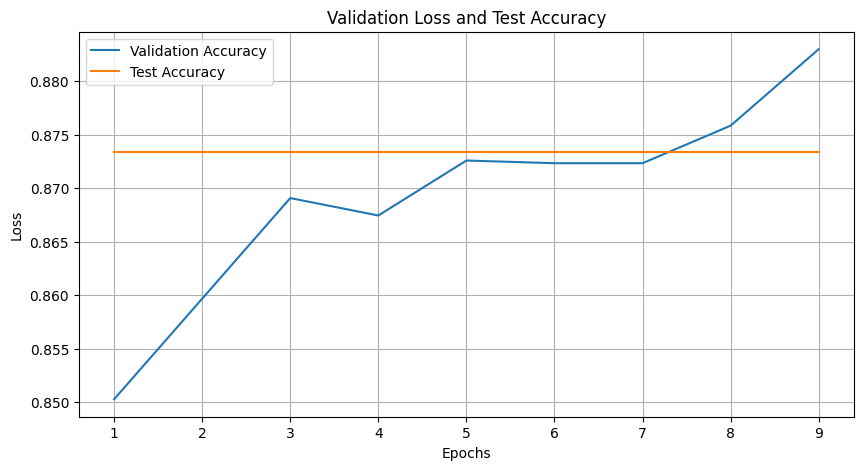

In [59]:
assert len(accuracies) > 0
assert test_accuracy > 0
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(accuracies) + 1), accuracies, label='Validation Accuracy')
plt.plot(range(1, len(accuracies) + 1), [test_accuracy for _ in range(len(accuracies))], label="Test Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss and Test Accuracy')
plt.legend()
plt.grid(True)
plt.show()

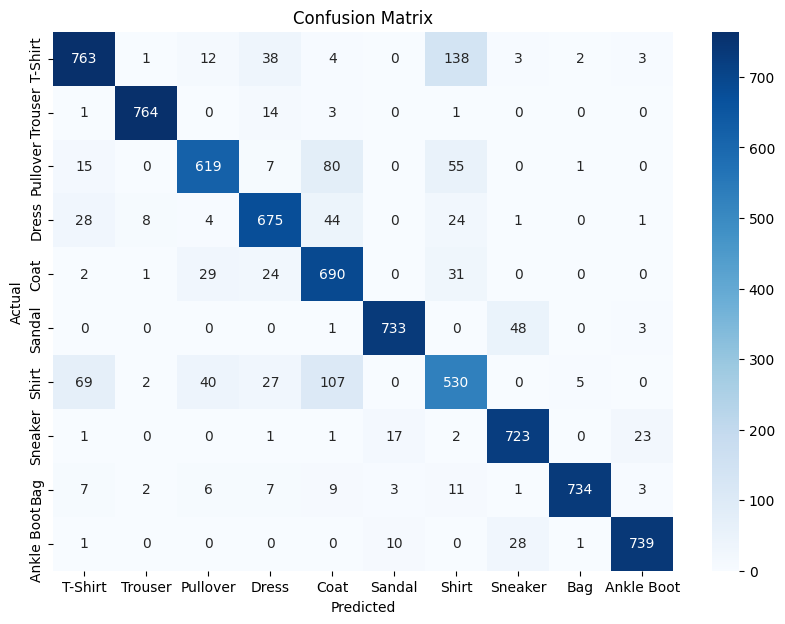

In [60]:
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=LABELS.values(), yticklabels=LABELS.values())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 13 Prediction

Generating the CSV to submit to DataHack.

In [68]:
submission_dataset = ApparelDataset.load(csv_path='data/test.csv', images_path='data/test', preprocessing=preprocessing)
submission_loader = DataLoader(submission_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=LOADER_WORKERS, pin_memory=False)
print("Submission dataset:", submission_dataset, len(submission_dataset), "records.")

Submission dataset: <apparel.ApparelDataset object at 0x15f1a4be0> 10000 records.


In [70]:
def predict(model: ApparelsModel, loader: DataLoader) -> np.array:
    y_hat = []
    model.eval() # Sets the model in evaluation model, which disables Dropout.
    start_time = time.time()
    with torch.no_grad():
        for batch_number, inputs in enumerate(loader):
            print(datetime.now(), "Prediction - Batch:", batch_number, "of", len(loader), "ETA:", get_eta(start_time, batch_number, len(loader)))
            inputs = inputs.to(PROCESSOR)
            outputs = model(inputs)
            predictions = torch.argmax(outputs, dim=1)
            y_hat.extend(predictions.cpu().numpy())
            if batch_number == STOP_AT_BATCH: break
    return y_hat

In [71]:
predictions = predict(model, submission_loader)

2024-06-24 15:00:49.054123 Prediction - Batch: 0 of 157 ETA: 2024-06-24 15:08:46.179363
2024-06-24 15:00:50.931577 Prediction - Batch: 1 of 157 ETA: 2024-06-24 15:13:37.895281
2024-06-24 15:00:52.857375 Prediction - Batch: 2 of 157 ETA: 2024-06-24 15:09:43.130440
2024-06-24 15:00:54.741906 Prediction - Batch: 3 of 157 ETA: 2024-06-24 15:08:22.715819
2024-06-24 15:00:56.621243 Prediction - Batch: 4 of 157 ETA: 2024-06-24 15:07:42.304638
2024-06-24 15:00:58.538891 Prediction - Batch: 5 of 157 ETA: 2024-06-24 15:07:19.260850
2024-06-24 15:01:00.337157 Prediction - Batch: 6 of 157 ETA: 2024-06-24 15:07:00.774510
2024-06-24 15:01:02.206410 Prediction - Batch: 7 of 157 ETA: 2024-06-24 15:06:49.162177
2024-06-24 15:01:04.110723 Prediction - Batch: 8 of 157 ETA: 2024-06-24 15:06:41.140947
2024-06-24 15:01:05.982974 Prediction - Batch: 9 of 157 ETA: 2024-06-24 15:06:34.342977
2024-06-24 15:01:07.796352 Prediction - Batch: 10 of 157 ETA: 2024-06-24 15:06:27.980151
2024-06-24 15:01:09.661333 Pred

/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, cur

In [72]:
if isinstance(STOP_AT_BATCH, int) and STOP_AT_BATCH >= 0:
    submission_dataset.df = submission_dataset.df.iloc[:len(predictions)].copy()
assert len(predictions) == len(submission_dataset)

submission_dataset.df['label'] = predictions
submission_dataset.df.to_csv(PREDICTIONS_PATH, index=False)

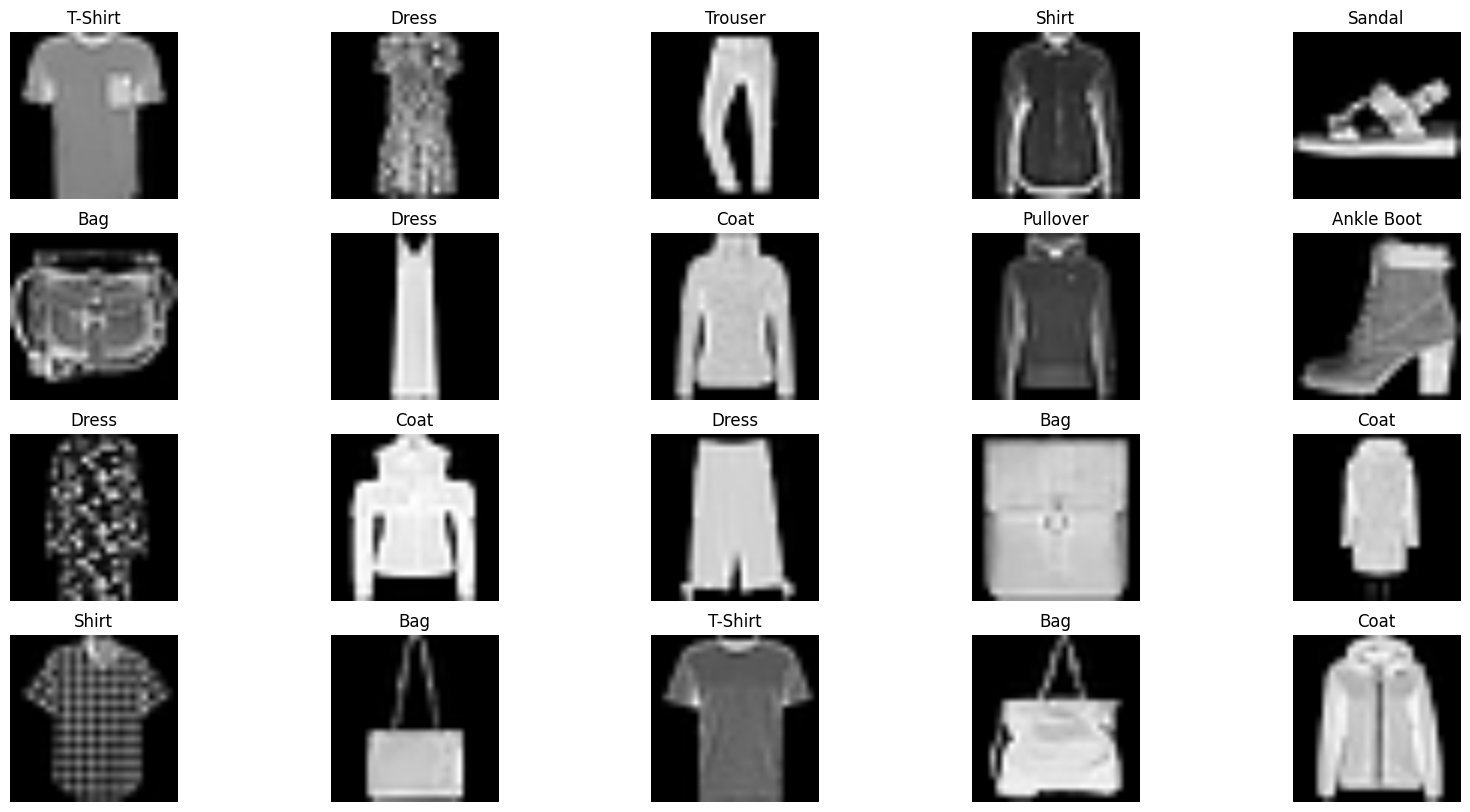

In [73]:
sample_dataset(submission_dataset)